[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rbouadjenek/deakin-simpsons-challenge2020/blob/main/deakin_ai_challenge_training.ipynb)

In [1]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright (c) 2020. Reda Bouadjenek, Deakin University                      +
#     Email:  reda.bouadjenek@deakin.edu.au                                    +
#                                                                              +
#  Licensed under the Apache License, Version 2.0 (the "License");             +
#   you may not use this file except in compliance with the License.           +
#    You may obtain a copy of the License at:                                  +
#                                                                              +
#                 http://www.apache.org/licenses/LICENSE-2.0                   +
#                                                                              +
#    Unless required by applicable law or agreed to in writing, software       +
#    distributed under the License is distributed on an "AS IS" BASIS,         +
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  +
#    See the License for the specific language governing permissions and       +
#    limitations under the License.                                            +
#                                                                              +
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [ ]:
# Run this to install the appropriate packages
!pip uninstall tensorboard -y
!pip uninstall tensorflow-estimator -y
!pip uninstall tensorflow-gpu -y
!pip install tensorflow==2.2.0


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections
import itertools


##################
# Verifications:
#################
print("GPU is user?: " + str(tf.test.is_gpu_available()))
print("Tensorflow version: " + tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is user?: True
Tensorflow version: 2.2.0


In [ ]:
# Download dataset.
!wget http://206.12.93.90:8080/simpson_dataset/simpsons_train.tar.gz
!tar -xzvf simpsons_train.tar.gz > /dev/null

In [3]:
'''
    Split train and validation.
'''
image_size = (128, 128)
batch_size = 64

image_generator = ImageDataGenerator(validation_split=0.1)

train_ds =  DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)
val_ds = DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

class_names = list(train_ds.class_indices.keys())
num_classes = train_ds.num_classes


Found 17627 images belonging to 20 classes.
Found 1947 images belonging to 20 classes.


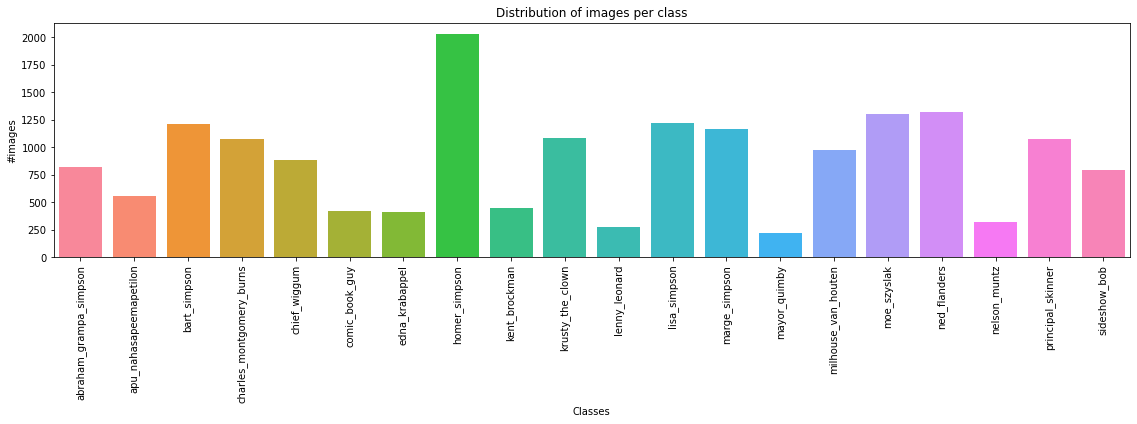

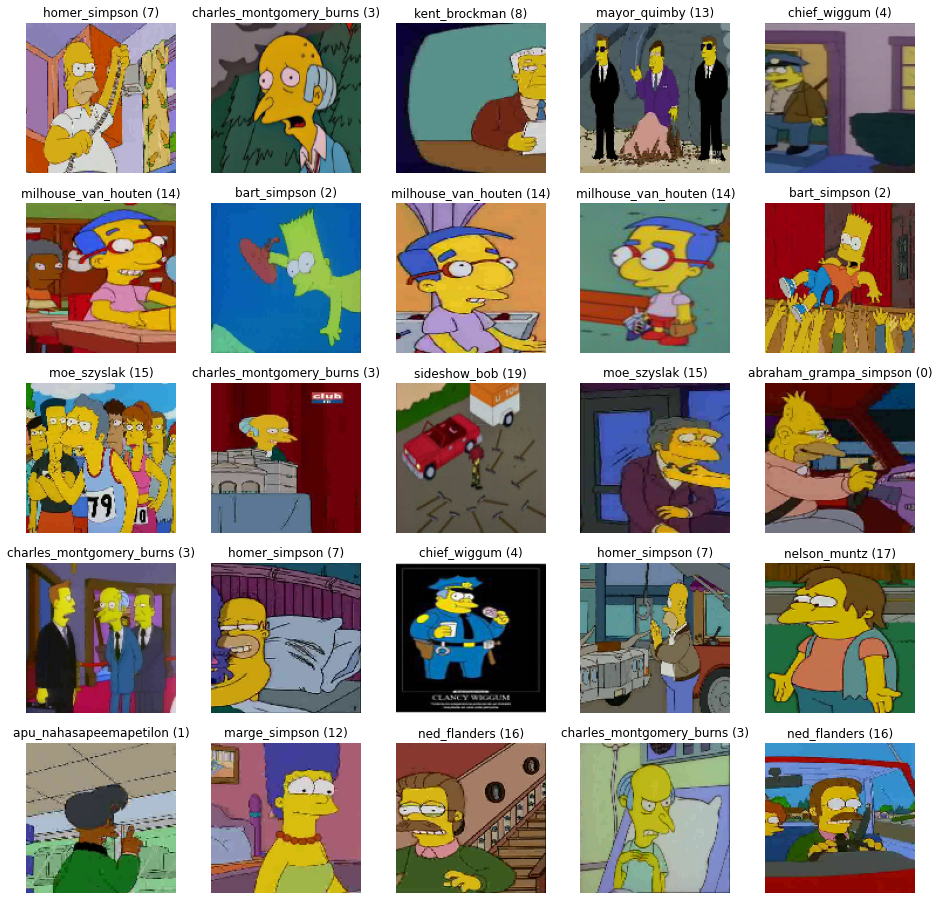

In [4]:
###############################################
#### Show distribution of images per class.
###############################################
counter=collections.Counter(train_ds.labels)
v = [ [class_names[item[0]],item[1]]  for item in counter.items()]
df = pd.DataFrame(data=v, columns=['index','value'])
g = sns.catplot(x='index', y= 'value',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class")
plt.xticks(rotation='vertical')
plt.show()

#####################################
######### Show sample of images.
#####################################
plt.figure(figsize=(16, 16))
images = []
labels = []
for itr in train_ds.next():
    for i in range(25):
        if len(images) < 25:
            images.append(itr[i].astype("uint8"))
        else:
            labels.append(list(itr[i]).index(1))

for i in range(len(images)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]]+' ('+str(int(labels[i]))+')')
    plt.axis("off")
    


In [14]:
model = models.Sequential()
model.add(keras.Input(shape=image_size + (3,))) 
model.add(layers.experimental.preprocessing.Rescaling(1./255))
# CNN block 1
model.add(layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# # CNN block 2     
model.add(layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
# # CNN block 3       
model.add(layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
#Dense part
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 128)      

In [15]:
history = model.fit(
    train_ds, epochs=8, 
    validation_data=val_ds,
)
with h5py.File('model.h5', mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['class_names'] = class_names
    f.attrs['image_size'] = image_size


Epoch 1/8
276/276 [==============================] - 37s 135ms/step - loss: 2.3218 - accuracy: 0.3095 - val_loss: 1.7132 - val_accuracy: 0.5054
Epoch 2/8
276/276 [==============================] - 37s 135ms/step - loss: 1.3495 - accuracy: 0.6090 - val_loss: 1.1866 - val_accuracy: 0.6574
Epoch 3/8
276/276 [==============================] - 37s 135ms/step - loss: 0.8761 - accuracy: 0.7470 - val_loss: 0.9855 - val_accuracy: 0.7093
Epoch 4/8
276/276 [==============================] - 37s 135ms/step - loss: 0.5737 - accuracy: 0.8331 - val_loss: 0.8593 - val_accuracy: 0.7740
Epoch 5/8
276/276 [==============================] - 37s 135ms/step - loss: 0.3524 - accuracy: 0.8953 - val_loss: 0.8866 - val_accuracy: 0.7745
Epoch 6/8
276/276 [==============================] - 37s 135ms/step - loss: 0.2188 - accuracy: 0.9327 - val_loss: 0.9949 - val_accuracy: 0.7879
Epoch 7/8
276/276 [==============================] - 37s 135ms/step - loss: 0.1347 - accuracy: 0.9596 - val_loss: 1.1398 - val_accuracy:

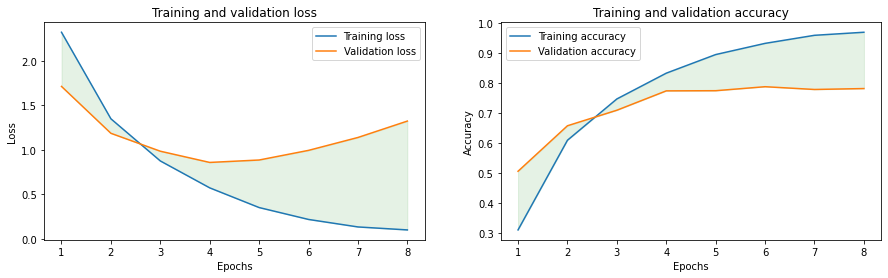

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.show()
ax2 = plt.subplot(1, 2, 2)

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    vmax = cm.max()
    if normalize:
        title = 'Confusion matrix (normalized)'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = [[int(j*100) for j in i ] for i in cm]
        cm =np.array(cm)
        vmax = 100
        
    plt.figure(figsize=(8,8))

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=vmax)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar(im,fraction=0.046, pad=0.04)



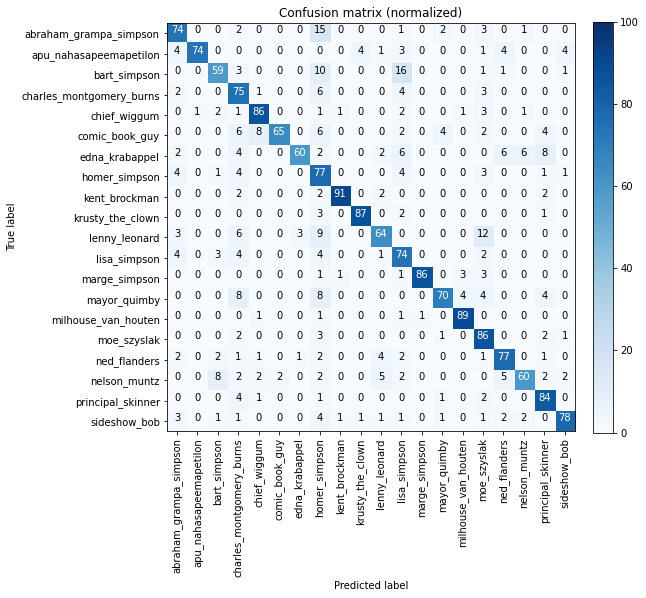

In [18]:
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)
y_true = val_ds.labels
cnf_matrix = confusion_matrix(y_true, y_predict)
plot_confusion_matrix(cm=cnf_matrix, classes=class_names, title='Confusion Matrix',normalize=True)
